In [1]:
# loading libraries to access Athena database
from aws_tools.athena_tools import AthenaQuerier as AQ
athena = AQ()

/home/ec2-user/SageMaker/anto/ee-addline-old/bin/virtual_env/lib/python3.7/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')


In [2]:
# loading libraries: pandas (of course), Pycaret as the framework to build/deploy models
import pandas as pd
!pip install pycaret[full]

# loading libraries for over/under sampling the oos
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#loading xgboost and catboost classifier libraries
import xgboost as xgb
from catboost import CatBoostClassifier

from pycaret.classification import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 73.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 12.7 MB/s eta 0:0

2022-11-21 10:15:15,782 [INFO ]  generated new fontManager


### Loading final model

In [3]:
#Simo version 1
loaded_model = load_model("/home/ec2-user/SageMaker/anto/ee-addline/model_objects/simo/v1_simo_27092022")

2022-11-21 10:15:36,193 [INFO ]  Initializing load_model()
2022-11-21 10:15:36,358 [INFO ]  load_model(model_name=/home/ec2-user/SageMaker/anto/ee-addline/model_objects/simo/v1_simo_27092022, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


##### upload SummerSales extract dataset

In [4]:
import os

In [5]:
#checking current directory
os.getcwd()

'/home/ec2-user/SageMaker/anto/Miscellaneous/ee-addline/validation models performance/SummerSales'

In [6]:
os.chdir('/home/ec2-user/SageMaker/anto/SummerSales_Models_Validation')

In [7]:
os.getcwd()

'/home/ec2-user/SageMaker/anto/SummerSales_Models_Validation'

In [8]:
import pandas as pd

In [9]:
df_extract = pd.read_csv('SummerSales.csv', index_col=False)

In [10]:
df_extract

,AccountNum,SubId,SaleDate,CtrlTarg,ProdGroup
0,122329532,1.169817e+09,07/06/2022,TARG,MBB
1,161322163,1.169836e+09,07/06/2022,TARG,MBB
2,194096585,1.169823e+09,07/06/2022,TARG,MBB
3,147589408,1.169822e+09,07/06/2022,TARG,MBB
4,111224373,1.169823e+09,07/06/2022,TARG,MBB
...,...,...,...,...,...
9811,104786336,1.170650e+09,01/07/2022,TARG,MBB SIMO
9812,116320751,1.170650e+09,01/07/2022,CTRL,MBB SIMO
9813,105577395,1.170657e+09,02/07/2022,TARG,MBB SIMO
9814,137216980,1.170678e+09,04/07/2022,CTRL,MBB SIMO


In [11]:
#exporting to S3 as csv
df_extract.to_csv("s3://bt-data-science-playground/ee_addline_rey/data/csv_files/SSExtract.csv")

In [13]:
from pyathena import connect
conn = connect(s3_staging_dir = 's3://aws-athena-query-results-341377015103-eu-west-2/',region_name='eu-west-2')

sql_query = '''
    CREATE EXTERNAL TABLE
        `bt_home_ds`.`SSExtract`(
          `index` bigint,
          `accountnum` bigint,
          `subid` bigint,
          `saledate` varchar(10),
          `ctrltarg` varchar(10),
          `prodgroup` varchar(25)
        )
    ROW FORMAT DELIMITED
        FIELDS TERMINATED BY '\,'
    STORED AS INPUTFORMAT
        'org.apache.hadoop.mapred.TextInputFormat'
    OUTPUTFORMAT
        'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 
        's3://bt-data-science-playground/ee_addline_rey/data/csv_files/'
    TBLPROPERTIES (
        'has_encrypted_data'='false',
        'skip.header.line.count'='1',
        'classification'='csv',
        'delimiter'='\,',
        'typeOfData'='file'
    )
'''
pd.read_sql(sql_query, conn)

""


In [67]:
#Script to identify customers tarteged
t = athena.execute_query(
    '''with campaign_data as (
select distinct
rec.subscriber_id, 
vlk.account_num,  
rec.mktg_activity_code,
rec.mktg_msg_code,
date_parse(reachability_date,'%Y-%m-%d') as reachability_date,
row_number() over(partition by vlk.account_num order by vlk.account_num, rec.reachability_date asc) as rn
FROM campaign_data.mcrh_reachability rec
inner join ee_paym_source.bi_ccm_base_history vlk on rec.subscriber_id = vlk.sub_id
where rec.mktg_activity_code = 'DR2000001383'
and date '2022-06-04' between from_date and to_date
)
select distinct
account_num,
1 as targetedBase
from campaign_data f
where rn =1
;''',return_df=True)
t

2022-11-10 16:13:56,206 [INFO ]  starting Athena query ...
2022-11-10 16:14:17,720 [INFO ]  Query Success - Statistics - Execution Duration: 0:00:20.950000; Data Scanned: 5.46 GB; Output_location: s3://aws-athena-query-results-341377015103-eu-west-2/37e49ca9-7011-495e-9efd-5b75e5adcdbe.csv
2022-11-10 16:14:17,804 [INFO ]  loading 37e49ca9-7011-495e-9efd-5b75e5adcdbe.csv
2022-11-10 16:14:20,599 [INFO ]  Athena query complete: returning dataframe


,account_num,targetedBase
0,129166192,1
1,118145599,1
2,116818258,1
3,123756505,1
4,134013702,1
...,...,...
1918728,104892356,1
1918729,114575644,1
1918730,151993996,1
1918731,140644008,1


In [3]:
# uploading the data
athena.execute_query("DROP TABLE IF EXISTS bt_home_ds.anto_eeadline_SummerSales", return_df=False)

sql_code = athena.execute_query(
    '''
    CREATE TABLE IF NOT EXISTS bt_home_ds.anto_eeadline_SummerSales
    WITH (
        format = 'PARQUET',
        parquet_compression = 'SNAPPY',
        external_location = 's3://bt-data-science-playground/ee_addline_rey/data/SummerSales/unseenDTA/'
        )  as 
        with campaign_data as (
        select distinct
        rec.subscriber_id, 
        vlk.account_num,  
        rec.mktg_activity_code,
        rec.mktg_msg_code,
        date_parse(reachability_date,'%Y-%m-%d') as reachability_date,
        row_number() over(partition by vlk.account_num order by vlk.account_num, rec.reachability_date asc) as rn
        FROM campaign_data.mcrh_reachability rec
        inner join ee_paym_source.bi_ccm_base_history vlk on rec.subscriber_id = vlk.sub_id
        where rec.mktg_activity_code = 'DR2000001383'
        and date '2022-06-04' between from_date and to_date
        )
        , targeted as (
        select distinct
        account_num as account,
        1 as targetedBase
        from campaign_data f
        where rn =1
        )
        , eeaddline as (
        select f.*,
        row_number() over(partition by account_num order by snapshot_date) as rn
        from bt_home_ds.ee_addline_rey_final f
        )
        , eeaddlinefinal as (
        select * 
        from eeaddline
        where rn = 1
        )
        , old_eeaddline as (
        select account_num,
        prob_hs_b,
        prob_simo_b,
        prob_tablet_b,
        prob_watch_b,
        score_date,
        dt,
        row_number() over(partition by account_num order by score_date) as rn
        from ds_model_output.ee_consumer_paym_cross_sell
        where score_date = '2022-06-04'
        )
        , old_eeaddlinefinal as (
        select * 
        from old_eeaddline
        where rn = 1      
        )
        , SSExtract as (
        select *
        from 
        bt_home_ds.SSExtract ie
        where ctrltarg <> 'CTRL'
        and prodgroup not in ('MBB', 'MBB SIMO')   
        )
        select 
        t.*,
        ef.*, 
        ex.*,
        oef.prob_hs_b,
        oef.prob_simo_b,
        oef.prob_tablet_b,
        oef.prob_watch_b,
        oef.score_date,
        oef.dt
        from eeaddlinefinal ef 
        left join old_eeaddlinefinal oef on oef.account_num = ef.account_num
        left join targeted t on t.account = ef.account_num
        left join SSExtract ex on ex.accountnum = ef.account_num
        ;''', return_df=False)

2022-11-11 12:27:16,357 [INFO ]  starting Athena query ...
2022-11-11 12:27:17,648 [INFO ]  Query Success - Statistics - Execution Duration: 0:00:00.842000; Data Scanned: 0 B; Output_location: s3://aws-athena-query-results-341377015103-eu-west-2/8271b6cb-4aed-4211-8467-e6072c42aac2.txt
2022-11-11 12:27:17,649 [INFO ]  Athena query complete
2022-11-11 12:27:17,649 [INFO ]  starting Athena query ...
2022-11-11 12:28:11,644 [INFO ]  Query Success - Statistics - Execution Duration: 0:00:53.302000; Data Scanned: 182.44 GB; Output_location: s3://aws-athena-query-results-341377015103-eu-west-2/tables/ffab6926-4803-4774-939d-c036cf853d2e
2022-11-11 12:28:11,645 [INFO ]  Athena query complete


### Uploading dataset

In [11]:
# uploading the data
athena.execute_query("DROP TABLE IF EXISTS bt_home_ds.anto_eeadline_SS_Handset", return_df=False)

sql_code = athena.execute_query(
    '''
    CREATE TABLE IF NOT EXISTS bt_home_ds.anto_eeadline_SS_Handset
    WITH (
        format = 'PARQUET',
        parquet_compression = 'SNAPPY',
        external_location = 's3://bt-data-science-playground/ee_addline_rey/data/SummerSales/unseen_handset/'
        ) as 
        (select * from bt_home_ds.anto_eeadline_SummerSales)
        ;''', return_df=False)

2022-11-08 12:03:22,064 [INFO ]  starting Athena query ...
2022-11-08 12:03:23,380 [INFO ]  Query Success - Statistics - Execution Duration: 0:00:00.413000; Data Scanned: 0 B; Output_location: s3://aws-athena-query-results-341377015103-eu-west-2/3fa292e9-7600-474f-8d8d-a73251c7670e.txt
2022-11-08 12:03:23,380 [INFO ]  Athena query complete
2022-11-08 12:03:23,381 [INFO ]  starting Athena query ...
2022-11-08 12:03:34,710 [INFO ]  Query Success - Statistics - Execution Duration: 0:00:11.078000; Data Scanned: 2.03 GB; Output_location: s3://aws-athena-query-results-341377015103-eu-west-2/tables/7442c161-5592-4c1e-b32c-b755ae0dee54
2022-11-08 12:03:34,710 [INFO ]  Athena query complete


In [4]:
unseen_dataset = athena.execute_query('select * from bt_home_ds.anto_eeadline_SummerSales where targetedBase=1', return_df=True)

2022-11-21 10:16:29,478 [INFO ]  starting Athena query ...
2022-11-21 10:17:58,360 [INFO ]  Query Success - Statistics - Execution Duration: 0:01:27.330000; Data Scanned: 1.03 GB; Output_location: s3://aws-athena-query-results-341377015103-eu-west-2/d4171e11-33c0-4c63-bed6-120b39a92ee2.csv
2022-11-21 10:17:58,486 [INFO ]  loading d4171e11-33c0-4c63-bed6-120b39a92ee2.csv
2022-11-21 10:21:52,297 [INFO ]  Athena query complete: returning dataframe


In [15]:
del unseen_dataset 

In [5]:
unseen_dataset.shape

(1919098, 191)

In [6]:
unseen_dataset.groupby(['prodgroup']).size()

prodgroup
HS SIMO    2789
Handset    2365
Tablet     1411
Watch      1694
dtype: int64

In [7]:
unseen_dataset.head()

,account,targetedbase,account_num,sub_id,subscriber_num,product_group_flag,y,snapshot_date,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pageviews_whyee_

In [8]:
unseen_dataset.rename(columns = {'y':'model_target'}, inplace = True)

In [9]:
unseen_dataset.head()

,account,targetedbase,account_num,sub_id,subscriber_num,product_group_flag,model_target,snapshot_date,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pagev

In [10]:
unseen_dataset['y'] = [1 if x == 'HS SIMO' else 0 for x in unseen_dataset['prodgroup']]

In [11]:
unseen_dataset.head()

,account,targetedbase,account_num,sub_id,subscriber_num,product_group_flag,model_target,snapshot_date,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pagev

In [12]:
unseen_dataset['y'] = unseen_dataset['y'].astype('int64') 
#oos_dataset_final.y = oos_dataset_final.y.astype('int64')

In [13]:
unseen_dataset.groupby(['y']).size()

y
0    1916309
1       2789
dtype: int64

In [14]:
unseen_dataset.groupby(['prodgroup']).size()

prodgroup
HS SIMO    2789
Handset    2365
Tablet     1411
Watch      1694
dtype: int64

In [16]:
to_drop = ["targetedbase", "account", "rn", "index", "accountnum", "account_num", "sub_id", "subid", "saledate", "ctrltarg", "prob_hs_b", "prob_tablet_b", "prob_watch_b", "score_date", "dt", "model_target","subscriber_num", "product_group_flag", "prodgroup", "snapshot_date"]

In [17]:
unseen_dataset = unseen_dataset.drop(to_drop, axis=1)

In [18]:
unseen_dataset.head()

,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pageviews_whyee_365d,web_pageviews_wifi_365d,app_pageviews_accessories_365d,app_pageviews_addons_365d,app_

In [19]:
oos_pred = predict_model(data=unseen_dataset, estimator = loaded_model, raw_score=True)

2022-11-15 16:17:34,926 [INFO ]  Initializing predict_model()
2022-11-15 16:17:34,927 [INFO ]  predict_model(estimator=Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['chan_group',
                                                            'chan_type',
                                                            'contract_allowance_mins',
                                                            'contract_allowance_text',
                                                            'device_type',
                                                            'iphone_flag',
                                                            'manufacturer',
                                                            'marketing_name',
                                                            'model', 'os',
                                                            'prev_base_type',
                                                            'product_group',

In [20]:
oos_pred.head()

,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pageviews_whyee_365d,web_pageviews_wifi_365d,app_pageviews_accessories_365d,app_pageviews_addons_365d,app_

In [21]:
oos_pred[(oos_pred['y'] == 1)]

,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pageviews_whyee_365d,web_pageviews_wifi_365d,app_pageviews_accessories_365d,app_pageviews_addons_365d,app_

In [22]:
oos_pred['percentile'] = pd.qcut(oos_pred['Score_1'].rank(method='first', ascending=True), 100, labels = list(range(1, 101)), duplicates='drop')

In [23]:
oos_pred['decile'] = pd.qcut(oos_pred['Score_1'].rank(method='first', ascending=False), 10, labels = list(range(1,11)), duplicates='drop')

In [26]:
oos_pred['decile_old_model'] = pd.qcut(oos_pred['prob_simo_b'].rank(method='first', ascending=False), 10, labels = list(range(1,11)), duplicates='drop')

In [27]:
oos_pred.head()

,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pageviews_whyee_365d,web_pageviews_wifi_365d,app_pageviews_accessories_365d,app_pageviews_addons_365d,app_

In [28]:
oos_pred.shape

(1919098, 178)

In [29]:
oos_actual_y = oos_pred['y'].astype(float)
oos_predictions = oos_pred['Label'].astype(float)

In [30]:
type(oos_predictions)

pandas.core.series.Series

In [31]:
oos_probabilities = oos_pred[['Score_0', 'Score_1']].astype(float)

In [32]:
oos_probabilities.head()

,Score_0,Score_1
0,0.8644,0.1356
1,0.8638,0.1362
2,0.5144,0.4856
3,0.8267,0.1733
4,0.3422,0.6578


In [33]:
oos_probabilities_arr = oos_probabilities.to_numpy()

In [34]:
type(oos_probabilities_arr)

numpy.ndarray

In [35]:
oos_probabilities_arr

array([[0.86440003, 0.1356    ],
       [0.86379999, 0.1362    ],
       [0.51440001, 0.48559999],
       ...,
       [0.4948    , 0.50520003],
       [0.91009998, 0.0899    ],
       [0.88919997, 0.1108    ]])

In [36]:
# To check the dimension of the array
#print("Shape of the array = ",np.shape(oos_probabilities));
print("Array Dimension = ",len(oos_probabilities.shape))

Array Dimension =  2


<Figure size 700x700 with 0 Axes>

2022-11-15 16:32:05,506 [WARNI]  findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-11-15 16:32:05,507 [WARNI]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
2022-11-15 16:32:05,526 [WARNI]  findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-11-15 16:32:05,527 [WARNI]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


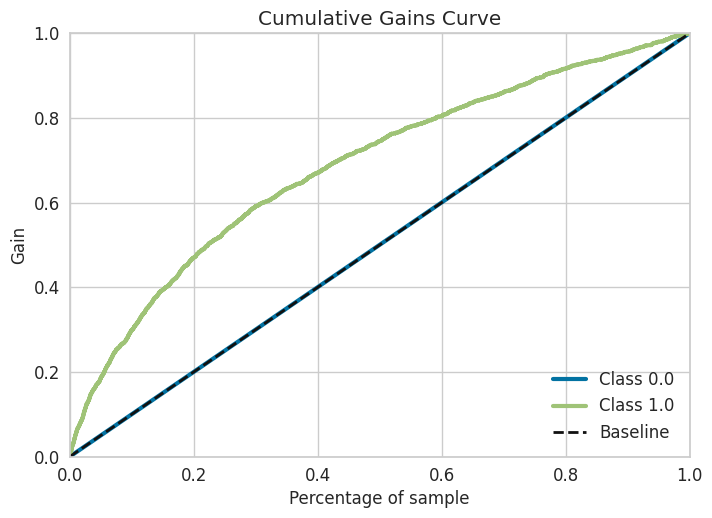

In [37]:
import scikitplot as skplt
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
skplt.metrics.plot_cumulative_gain(oos_actual_y, oos_probabilities)
#plt.savefig("gain_oos.png", format="png")
plt.show()

In [38]:
oos_pred.head()

,cnt_base_addon,cnt_base_essential,cnt_base_handset,cnt_base_mbb_connected,cnt_base_mbb_device,cnt_base_mbb_device_contract,cnt_base_mbb_device_rolling,cnt_base_mbb_simo,cnt_base_simo,cnt_base_simo_contract,cnt_base_simo_rolling,cnt_base_smart,cnt_base_tablet,cnt_base_unknown,cnt_base_watch,mrc_base_addon,mrc_base_essential,mrc_base_handset,mrc_base_mbb_connected,mrc_base_mbb_device,mrc_base_mbb_device_contract,mrc_base_mbb_device_rolling,mrc_base_mbb_simo,mrc_base_simo,mrc_base_simo_contract,mrc_base_simo_rolling,mrc_base_smart,mrc_base_tablet,mrc_base_unknown,mrc_base_watch,tot_mrc_incl_vat,tot_ported_in_flag,tot_products,base_type,chan_group,chan_type,concept_class,contract_allowance_mins,contract_allowance_text,contract_data_group,contract_duration,customer_age,device_type,gender,iphone_flag,manufacturer,marketing_name,mig_from_payg_flag,mig_from_payg_months,model,no_of_upgrades,os,payment_method,ported_in_flag,ported_in_from,prev_base_type,product_group,protocol,screen_size,sharer_flag,smartphone,tenure_brand_months,tenure_lifetime_months,tenure_priceplan_months,total_allowance_data,total_allowance_mins,total_allowance_text,volte_flag,vowifi_flag,call_count_365_days,avg_addons_discount_12m,avg_addons_revenue_12m,avg_core_discounts_12m,avg_inbound_call_total_count_12m,avg_inbound_call_total_duration_12m,avg_inbound_sms_total_12m,avg_insurance_discounts_12m,avg_insurance_revenue_12m,avg_one_off_revenue_12m,avg_outbound_call_allowed_duration_12m,avg_outbound_call_total_count_12m,avg_outbound_call_total_duration_12m,avg_outbound_sms_total_12m,avg_plan_usage_12m,avg_total_data_usage_12m,total_data_gifted_12m,total_data_received_12m,total_mrc_spend_12m,total_one_off_allowance_12m,total_one_off_passes_12m,total_one_off_spend_12m,total_passes_purchased_12m,total_recurring_allowance_12m,total_recurring_cost_12m,total_times_gifting_12m,total_times_received_12m,visits_count_365d,web_clicks_chooseplan_365d,web_feedbacksubmitted_medalliacount_365d,web_pageviews_5gonee_365d,web_pageviews_accessories_365d,web_pageviews_acqbenefits_365d,web_pageviews_acqcheckout_365d,web_pageviews_acqdelivery_365d,web_pageviews_acqextras_365d,web_pageviews_addtoplan_365d,web_pageviews_addtoplan_playstation_365d,web_pageviews_addtoplan_razer_365d,web_pageviews_addtoplan_stadia_365d,web_pageviews_addtoplan_xbox_365d,web_pageviews_amazon_365d,web_pageviews_audio_365d,web_pageviews_authgallery_365d,web_pageviews_authpdp_365d,web_pageviews_authpdpiphone_365d,web_pageviews_authpdpsamsung_365d,web_pageviews_authwatchpdp_365d,web_pageviews_benefits_365d,web_pageviews_britbox_365d,web_pageviews_checkusage_365d,web_pageviews_communitygaming_365d,web_pageviews_communitygaming_playstation_365d,web_pageviews_communitygaming_razer_365d,web_pageviews_communitygaming_stadia_365d,web_pageviews_communitygaming_xbox_365d,web_pageviews_contain5g_365d,web_pageviews_coverage_365d,web_pageviews_desktopcount_365d,web_pageviews_gaminghome_365d,web_pageviews_headphones_365d,web_pageviews_help_365d,web_pageviews_loggedin_365d,web_pageviews_loggedout_365d,web_pageviews_makepayment_365d,web_pageviews_mobilecount_365d,web_pageviews_mobiledata_365d,web_pageviews_music_365d,web_pageviews_mybillsandpayments_365d,web_pageviews_resetpassword_365d,web_pageviews_simonly_365d,web_pageviews_smarthome_365d,web_pageviews_smarthomealexa_365d,web_pageviews_smarthomehive_365d,web_pageviews_smarthomehomepod_365d,web_pageviews_smarthomenest_365d,web_pageviews_speakers_365d,web_pageviews_sport_365d,web_pageviews_storefinder_365d,web_pageviews_tabletcount_365d,web_pageviews_unauthgallery_365d,web_pageviews_unauthpdp_365d,web_pageviews_unauthpdpiphone_365d,web_pageviews_unauthpdpsamsung_365d,web_pageviews_unauthwatchpdp_365d,web_pageviews_upgrade_365d,web_pageviews_upgradebenefits_365d,web_pageviews_upgradecheckout_365d,web_pageviews_upgradeextras_365d,web_pageviews_upgraderecommendations_365d,web_pageviews_whyee_365d,web_pageviews_wifi_365d,app_pageviews_accessories_365d,app_pageviews_addons_365d,app_

In [39]:
table_summary_newMODEL = oos_pred.groupby("decile").agg(count = ("y","count"), actual = ("y","sum"))

In [40]:
table_summary_newMODEL['Cumulative actual'] = table_summary_newMODEL['actual'].cumsum()

In [41]:
table_summary_newMODEL['Cumulative Abs values'] = table_summary_newMODEL['actual'].cumsum()/ table_summary_newMODEL['actual'].sum()

In [42]:
table_summary_newMODEL['Cumulative %'] = table_summary_newMODEL['Cumulative Abs values'].apply(lambda x: f'{x:.2%}')

In [43]:
table_summary_newMODEL.reset_index(inplace=True)
table_summary_newMODEL

,decile,count,actual,Cumulative actual,Cumulative Abs values,Cumulative %
0,1,191910,834,834,0.299032,29.90%
1,2,191910,477,1311,0.470061,47.01%
2,3,191910,337,1648,0.590893,59.09%
3,4,191909,223,1871,0.670850,67.08%
4,5,191910,208,2079,0.745428,74.54%
5,6,191910,164,2243,0.804231,80.42%
6,7,191909,158,2401,0.860882,86.09%
7,8,191910,155,2556,0.916458,91.65%
8,9,191910,112,2668,0.956615,95.66%
9,10,191910,121,2789,1.000000,100.00%


In [44]:
table_summary_newMODEL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   decile                 10 non-null     category
 1   count                  10 non-null     int64   
 2   actual                 10 non-null     int64   
 3   Cumulative actual      10 non-null     int64   
 4   Cumulative Abs values  10 non-null     float64 
 5   Cumulative %           10 non-null     object  
dtypes: category(1), float64(1), int64(3), object(1)
memory usage: 918.0+ bytes


In [45]:
plot_cum = list(table_summary_newMODEL['Cumulative Abs values'])
plot_cum

[0.2990319110792399,
 0.4700609537468627,
 0.5908927931158121,
 0.6708497669415561,
 0.7454284689852994,
 0.8042309071351739,
 0.8608820365722482,
 0.9164575116529222,
 0.9566152742918609,
 1.0]

### Old Model Summary

In [47]:
oos_probabilities_old = oos_pred['prob_simo_b'].to_frame()

In [51]:
oos_probabilities_old.rename(columns = {'prob_simo_b':'Score_1'}, inplace = True)

In [52]:
oos_probabilities_old['Score_0'] = 1 - oos_probabilities_old['Score_1']

In [53]:
oos_probabilities_old = oos_probabilities_old[['Score_0', 'Score_1']]

In [54]:
oos_probabilities_old

,Score_0,Score_1
0,0.791026,0.208974
1,0.951282,0.048718
2,0.808974,0.191026
3,0.961538,0.038462
4,0.442949,0.557051
...,...,...
1919093,0.731538,0.268462
1919094,0.805495,0.194505
1919095,0.642308,0.357692
1919096,0.811538,0.188462


In [55]:
oos_probabilities_old_arr = oos_probabilities_old.to_numpy()

<Figure size 700x700 with 0 Axes>

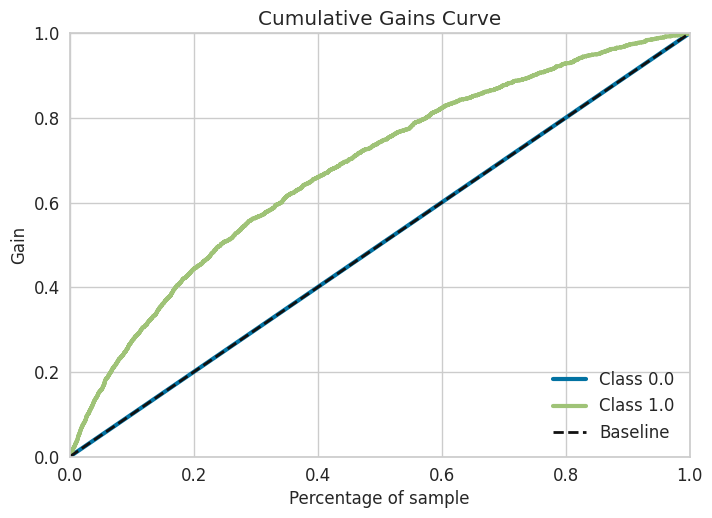

In [56]:
plt.figure(figsize=(7,7))
skplt.metrics.plot_cumulative_gain(oos_actual_y, oos_probabilities_old_arr)
#plt.savefig("gain_oos.png", format="png")
plt.show()

In [57]:
table_summary_oldMODEL = oos_pred.groupby("decile_old_model").agg(count = ("y","count"), actual = ("y","sum"))

In [58]:
table_summary_oldMODEL['Cumulative actual'] = table_summary_oldMODEL['actual'].cumsum()

In [59]:
table_summary_oldMODEL['Cumulative Abs values'] = table_summary_oldMODEL['actual'].cumsum()/ table_summary_oldMODEL['actual'].sum()

In [60]:
table_summary_oldMODEL['Cumulative %'] = table_summary_oldMODEL['Cumulative Abs values'].apply(lambda x: f'{x:.2%}')

In [61]:
table_summary_oldMODEL.reset_index(inplace=True)
table_summary_oldMODEL

,decile_old_model,count,actual,Cumulative actual,Cumulative Abs values,Cumulative %
0,1,191909,759,759,0.272141,27.21%
1,2,191908,475,1234,0.442452,44.25%
2,3,191909,341,1575,0.564719,56.47%
3,4,191908,263,1838,0.659018,65.90%
4,5,191909,233,2071,0.742560,74.26%
5,6,191908,225,2296,0.823234,82.32%
6,7,191908,151,2447,0.877375,87.74%
7,8,191909,142,2589,0.928290,92.83%
8,9,191908,121,2710,0.971674,97.17%
9,10,191909,79,2789,1.000000,100.00%


In [62]:
plot_cum_old = list(table_summary_oldMODEL['Cumulative Abs values'])
plot_cum_old

[0.27214055216923627,
 0.44245249193259234,
 0.5647185371100752,
 0.6590175690211545,
 0.7425600573682324,
 0.8232341340982431,
 0.8773754033703837,
 0.9282897095733238,
 0.9716744352814629,
 1.0]

In [63]:
count = list(table_summary_oldMODEL['count'])
count

[191909,
 191908,
 191909,
 191908,
 191909,
 191908,
 191908,
 191909,
 191908,
 191909]

### Plotting both Models

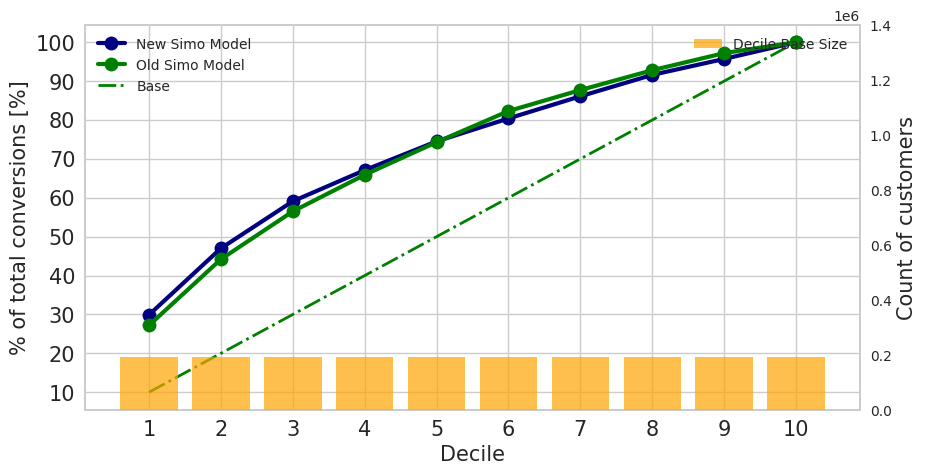

In [65]:
decile = [1,2,3,4,5,6,7,8,9,10]

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(decile, [round(x*100,1) for x in plot_cum], marker='o', c='Navy', markersize=10, linewidth=3, label="New Simo Model", zorder=10)
plt.plot(decile, [round(x*100,1) for x in plot_cum_old], marker='o', c='green', markersize=10, linewidth=3, label="Old Model", zorder=10)
plt.plot([1, 10], [10,100 ], color='green', linestyle='dashdot', linewidth=2, label="Base", zorder=10)
plt.xlabel('Decile', fontsize=15)
plt.legend(loc='best')
plt.ylabel('% of total conversions [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)

ax2 = ax.twinx()

ax2.bar(decile, count, color='orange', label='Decile Base Size', zorder=11, alpha=0.7)
#ax2.bar(deciles + width, base, width, color='blue', label='Decile base size', zorder=11, alpha=0.7)
ax2.legend(loc=1)

ax2.set_ylim(0, 1400000)
ax2.set_ylabel('Count of customers', fontsize=15)
plt.grid()
plt.show()